In [12]:
import scipy.io
import pandas as pd
import os
import numpy as np
from scipy.signal import butter, filtfilt, welch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statistics import mode
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import LeaveOneGroupOut

### Import files

In [13]:
folder_path = os.getcwd() + '\\dataset\\'
files = os.listdir(folder_path)

#Get only files related to left_pocket
left_pocket = [file for file in files if file.endswith('left_pocket.mat')]
truth = [file for file in files if file.endswith('truth.mat')]

In [14]:
# Create dataframes for all participants
for i, file_name in enumerate(left_pocket):
    data = scipy.io.loadmat(folder_path + file_name)
    activity = scipy.io.loadmat(folder_path + truth[i])
    t = data['t'].ravel()
    x = data['x'].ravel()
    x, y, z = np.array_split(x, 3)
    label = activity['label'].ravel()
    label = [x[0] for x in label]
    globals()[f'df{i+1}'] = pd.DataFrame({'t':t, 'x':x, 'y':y, 'z':z, 'activity':label})

df_names = ['df1','df2','df3','df4','df5','df6','df7','df8','df9','df10']
data_frames = []
for name in df_names:
    data_frames.append(globals()[name])

df9['activity'] = df9['activity'].replace('upsatirs', 'upstairs')

### Preprocessing

#### Convert 3D accelerometer signal to 1D

In [15]:
for i in range(len(df_names)):
    df = globals()[f'df{i+1}']
    
    # calculate the magnitude of the acceleration vector
    acc_mag = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    df['acc_mag'] = acc_mag
    globals()[f'df{i+1}'] = df

#### Replace sensor errors with previous value

In [16]:
for df in data_frames:
    error_values = df['acc_mag'] > 1000
    df.loc[error_values, 'acc_mag'] = df['acc_mag'].shift(1)[error_values]

#### Apply high-pass Butterworth filter

In [17]:
samp_freq = 100
cut_freq = 1
nyq_freq = 0.5*samp_freq

#Normalize cutoff frequecy
cutoff = cut_freq/nyq_freq 
# 4th order Butterworth filter
b, a = butter(4, cutoff, btype='highpass')

#Apply filter to each dataframe
for df in data_frames:
    acc_mag = df['acc_mag']
    acc_mag_filt = filtfilt(b, a, acc_mag)
    df['acc_mag_filt'] = acc_mag_filt

### Feature extraction

In [18]:
window_len = 100    # 1 second with a sampling frequency of 100 Hz
windows_step = 100  # 1 second with a step of 1 second
num_frequency_bands = 10
band_limits = [nyq_freq / 2 ** (num_frequency_bands - i) for i in range(num_frequency_bands)]

data_frames_processed = {}
dfs_processed = {}

for i, df in enumerate(data_frames):
    features = []
    labels = []

    for j in range(0, len(df)-window_len+1, windows_step):
        window = df['acc_mag_filt'][j:j+window_len]
        freq, power_spectrum = welch(window, fs=100, nperseg=window_len, noverlap=0)

        power_in_bands = [] #  power in each frequency band
        for k in range(len(band_limits)):
            freqs_in_band = np.where((freq >= band_limits[k]) & (freq < band_limits[k+1]))[0] if k < len(band_limits)-1 else np.where(freq >= band_limits[k])[0]
            power_in_bands.append(np.sum(power_spectrum[freqs_in_band]))

        features.append(power_in_bands)

        window_labels = df['activity'][j:j+window_len].values
        label = mode(window_labels)
        labels.append(label)

    # Normalize features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    # Create new dataframe with windowed features and labels
    df_processed = pd.DataFrame(normalized_features, columns=['f' + str(k) for k in range(len(normalized_features[0]))])
    df_processed['activity'] = labels

    # Append dataframe to list
    data_frames_processed[i] = df_processed
    dfs_processed[f'df_p{i+1}'] = df_processed


# Create new dataframe variables
for i, key in enumerate(dfs_processed.keys()):
    name = f"df_p{i+1}"
    globals()[name] = dfs_processed[key]


### LOSO training using SVM classifier

In [19]:
logo = LeaveOneGroupOut()

X = pd.concat([df_p1.iloc[:,:-1], df_p2.iloc[:,:-1], df_p3.iloc[:,:-1], df_p4.iloc[:,:-1], df_p5.iloc[:,:-1], df_p6.iloc[:,:-1], df_p7.iloc[:,:-1], df_p8.iloc[:,:-1], df_p9.iloc[:,:-1], df_p10.iloc[:,:-1]])
y = pd.concat([df_p1['activity'], df_p2['activity'], df_p3['activity'], df_p4['activity'], df_p5['activity'], df_p6['activity'], df_p7['activity'], df_p8['activity'], df_p9['activity'], df_p10['activity']])
groups = ['p1']*len(df_p1) + ['p2']*len(df_p2) + ['p3']*len(df_p3) + ['p4']*len(df_p4) + ['p5']*len(df_p5) + ['p6']*len(df_p6) + ['p7']*len(df_p7) + ['p8']*len(df_p8) + ['p9']*len(df_p9) + ['p10']*len(df_p10)

In [20]:
confusion_matrices = []
accuracies = []
for train_index, test_index in logo.split(X, y, groups=groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    p = X_train.shape[1]
    gamma = 1/p
    
    clf = SVC(kernel='rbf', C=1, gamma=gamma)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, normalize='true')*100
    confusion_matrices.append(cm)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
final_cm = sum(confusion_matrices)
summarized_accuracy = np.mean(accuracies)
print(classification_report(y, clf.predict(X)))

              precision    recall  f1-score   support

      biking       0.46      0.35      0.40       900
  downstairs       0.49      0.56      0.52       900
     jogging       0.57      0.39      0.46       900
     sitting       0.45      0.78      0.57       900
    standing       0.76      0.80      0.78       900
    upstairs       0.53      0.43      0.48       900
     walking       0.49      0.39      0.43       900

    accuracy                           0.53      6300
   macro avg       0.53      0.53      0.52      6300
weighted avg       0.53      0.53      0.52      6300



In [24]:
print(f"Accuracy: {summarized_accuracy:.2%}")

Accuracy: 48.75%


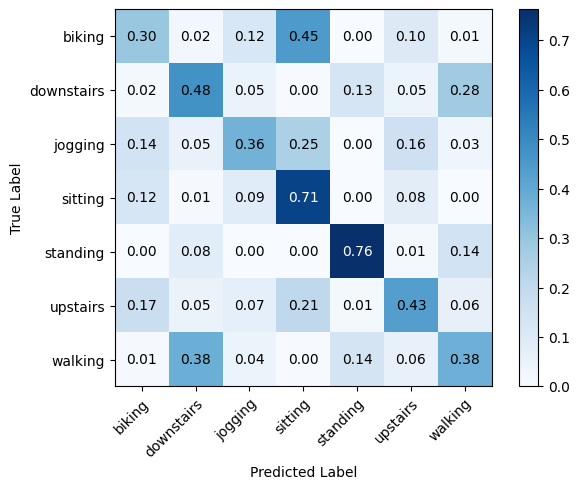

In [22]:
classes = np.unique(y)
norm_cm = final_cm / final_cm.sum(axis=1, keepdims=True)
fig, ax = plt.subplots()
im = ax.imshow(norm_cm, cmap='Blues')
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, format(norm_cm[i, j], '.2f'),
                       ha="center", va="center", color="white" if norm_cm[i, j] > 0.5 else "black");
cbar = ax.figure.colorbar(im, ax=ax)
fig.tight_layout()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix_left_pocket.png', bbox_inches='tight')